In [1]:
import sys
sys.path.append('../../../patronus/')
from global_config import * # load REPO_HOME_DIR, DATASET_DIR

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


from train.utils import load_patronus_unet_model
from models.diffusion import SimpleDiffusion
from train.dataloader import get_dataloader
from analysis.analysis_utils import get_samples_from_loader, vis_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reconstruction, and Variations with fixed s, random xT
Figure 3 in the paper.

## 1 - Define the dataset and trained version that you would like to inspect on

In [30]:
ds = 'CelebA'
version_num = 4
print(f'Selecting dataset: {ds} version {version_num}')

Selecting dataset: CelebA version 4


## 2 – Load trained model, initialize diffusion schedule, load test set

In [1]:
# ---- Load the patronus model -----
print('*'*30 + 'Load model' + '*'*30)
model, patronus_config_set = load_patronus_unet_model(ds_name=ds, 
                                                    version_num=version_num,
                            )

 # ---- Load the diffusion schduler ----
sd = SimpleDiffusion(
        num_diffusion_timesteps = patronus_config_set['TrainingConfig']['TIMESTEPS'],
        img_shape               = patronus_config_set['TrainingConfig']['IMG_SHAPE'],
        device                  = patronus_config_set['BaseConfig']['DEVICE'],
)

# ---- Load the test set ----- 
# we use test set to avoid memorization from the training set
dataloader_test = get_dataloader(
        dataset_name=f'{ds}-test',
        batch_size=128,
        device='cpu',
        shuffle = True, 
)

# # ---- Get the plausible maximum prototype similarity score ----
for i, (b_image, extra_info) in enumerate(dataloader_test):
    pact = model.proactBlock(b_image.to(device))
    b_img_id = extra_info[1]
    max_pact = torch.max(pact).detach().cpu()
    break
# print(f'Maximum prototype similarity score: {max_pact}')

## Select one sample to play with

Randomly picked sample index: 96
selected_img.shape=torch.Size([1, 3, 64, 64]), selected_sample_id=['192470.jpg']


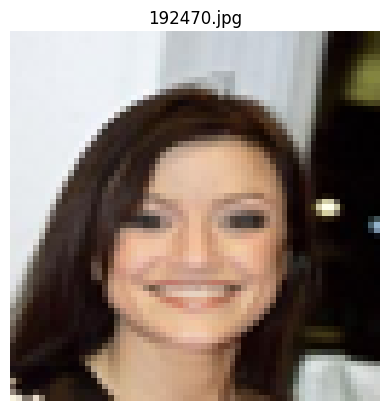

In [41]:

# selected_sample_id = ['200877.jpg'] # <-- CelebA
# selected_img = get_samples_from_loader(dataloader_test, selected_sample_id)


# random select
torch.random.manual_seed(2)
random_picked_idx = torch.randint(0, len(dataloader_test), (1,)).item()
print(f'Randomly picked sample index: {random_picked_idx}')

# get one specific image
selected_img = b_image[random_picked_idx].unsqueeze(0)
selected_sample_id = [b_img_id[random_picked_idx]]

print(f'{selected_img.shape=}, {selected_sample_id=}')

vis_samples(selected_img, selected_sample_id)

## Get prototype activation vector and x_T

In [42]:
selected_pact = model.proactBlock(selected_img.to(device))
selected_xT = sd.reverse_sample_loop(model,selected_img.to(device), model_kwargs={'given_cond_vector':selected_pact})['sample']

## Visualize the xT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011158705..1.0585289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.466053..6.010484].


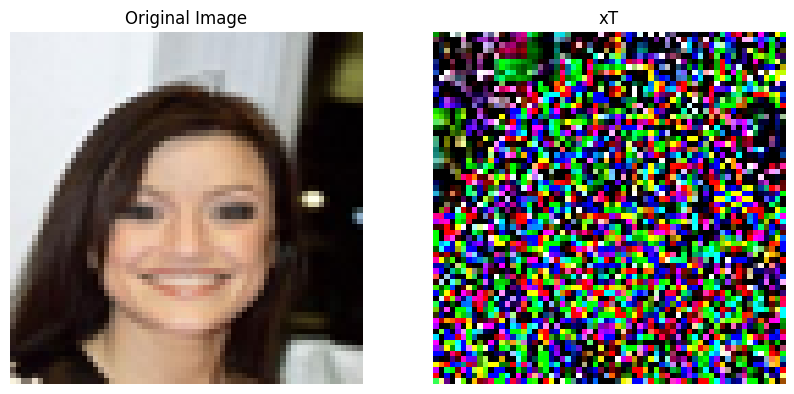

In [43]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (selected_img+1)/2
if selected_img.shape[1] == 1:
    cmap = 'gray'
else:
    cmap = None
ax[0].imshow(ori[0].permute(1, 2, 0).cpu(),cmap=cmap)
ax[0].set_title('Original Image')
ax[1].imshow(selected_xT[0].permute(1, 2, 0).cpu(),cmap=cmap)
ax[1].set_title('xT')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

## 3 - Recontruction (using the same xT and same prototype activation vector)

In [44]:
x_0_recon = sd.sample(model,
                      shape=selected_img.shape,
                      noise=selected_xT,
                      progress=True,
                      model_kwargs={'given_cond_vector':selected_pact},
                      num_samples=1)

DEBUG:img.shape=torch.Size([1, 3, 64, 64])


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011158705..1.0585289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009603143..1.0442718].


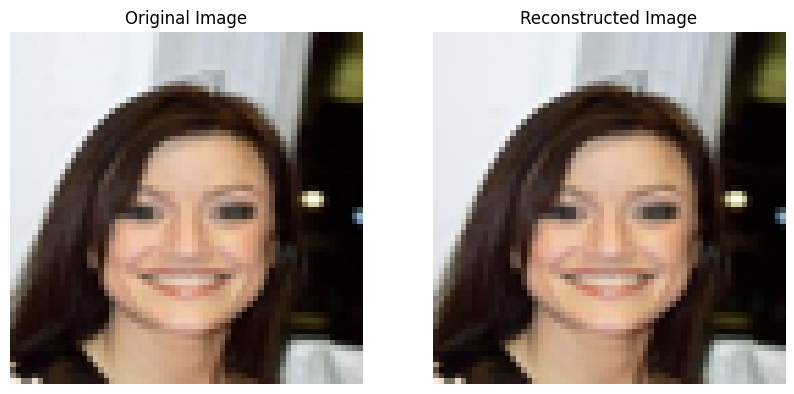

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (selected_img+1)/2
new = (x_0_recon+1)/2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu(),cmap=cmap)
ax[1].imshow(new[0].permute(1, 2, 0).cpu(),cmap=cmap)
ax[0].set_title('Original Image')
ax[1].set_title('Reconstructed Image')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

## 4 - Variations with fixed s, random xT

In [46]:
num_samples = 5
x_0_random_xT = sd.sample(model,
                      shape=selected_img.shape,
                      noise=None,
                      progress=True,
                      model_kwargs={'given_cond_vector':selected_pact},
                      num_samples=num_samples,
                      eta=0.0)


DEBUG:img.shape=torch.Size([5, 3, 64, 64])


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011158705..1.0585289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013572037..1.0182459].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007649064..0.978748].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015646935..0.9820189].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015604317..0.9989532].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011583209..0.98324156].


ori.shape=torch.Size([1, 3, 64, 64])
new.shape=torch.Size([5, 3, 64, 64])


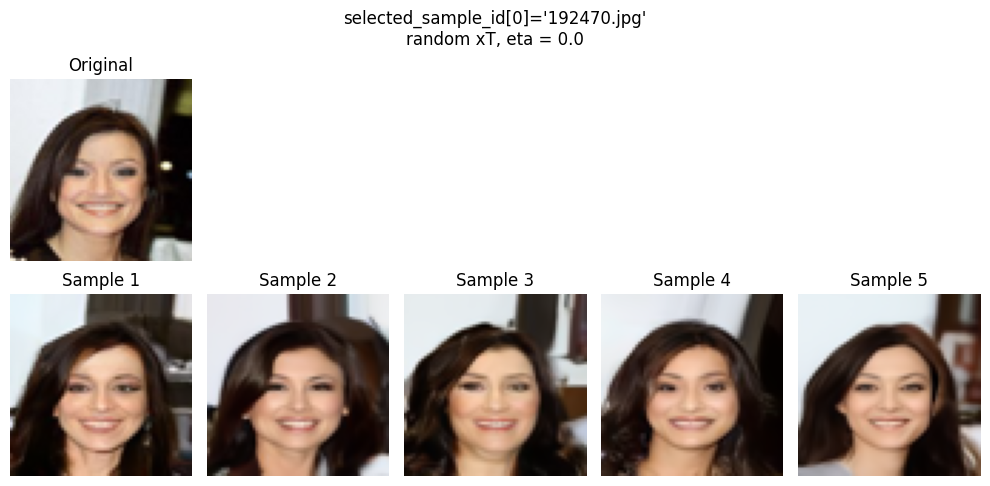

In [47]:
fig, ax = plt.subplots(2, num_samples, figsize=(num_samples*2, 5))
ori = (selected_img+1)/2
new = (x_0_random_xT+1)/2
print(f'{ori.shape=}')
print(f'{new.shape=}')
ax[0,0].imshow(ori[0].permute(1, 2, 0).cpu(),cmap=cmap)
ax[0,0].set_title('Original')
for i in range(num_samples):
    ax[1,i].imshow(new[i].permute(1, 2, 0).cpu(),cmap=cmap)
    ax[1,i].set_title(f'Sample {i+1}')
    ax[0,i].axis("off")
    ax[1,i].axis("off")
plt.axis("off")
plt.suptitle(f'{selected_sample_id[0]=}\nrandom xT, eta = {0.0}')
plt.tight_layout()
plt.show()